#### This notebook computes a new predictive feature per match (deck-strategy combination).
#### The outcome class is determined based on whether or not the predictive feature falls in the overlapping range (undefined range) of two classes. If it is within the non-overlapping range (green/red arrows in the figure below), it is not considered.
#### For each patient, we calculate the "weighted AUC", by multiplying the original predictive feature by the AUC.
#### The new predictive feature is then summed for all matches, per patient.
#### We then compute the new AUC, based on the new predictive feature.

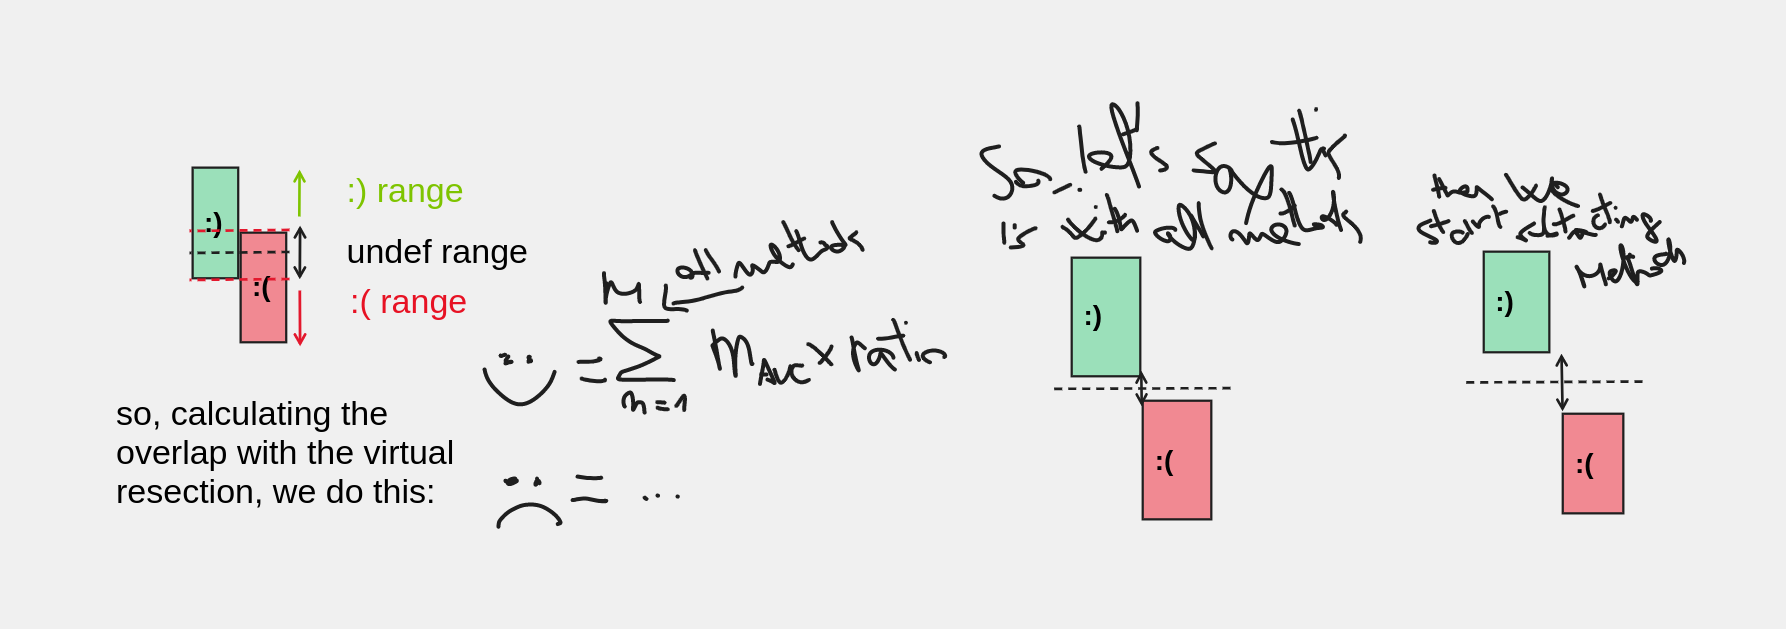

In [ ]:
conn_measures = ["PAC",
                 "SCR-(0,4)","SCR-(4,8)","SCR-(8,13)","SCR-(13,30)","SCR-(30,70)","SCR-(70,150)",
                "SCI-(0,4)","SCI-(4,8)","SCI-(8,13)","SCI-(13,30)","SCI-(30,70)","SCI-(70,150)",
                "PLV-(0,4)","PLV-(4,8)","PLV-(8,13)","PLV-(13,30)","PLV-(30,70)","PLV-(70,150)",
                "PLI-(0,4)", "PLI-(4,8)", "PLI-(8,13)", "PLI-(13,30)", "PLI-(30,70)", "PLI-(70,150)", 
                "CC-(0,4)","CC-(4,8)","CC-(8,13)","CC-(13,30)","CC-(30,70)","CC-(70,150)"] 

In [ ]:
import pandas as pd
from pickle import load, dump
import numpy as np

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# main_folder = "/content/gdrive/My Drive/epigame-folder/"

main_folder = "/home/kivi/gdrive/epigame-folder/"

path_res = main_folder + "cvs_pairs/"

path_deck = main_folder + "decks/"
path_scores = main_folder + "game_scores/"

woi = "preseizure1"

In [ ]:
def to_labels(pos_probs, threshold):
    # function to map all values >=threshold to 1 and all values <threshold to 0

	return list((pos_probs >= threshold).astype('int')) 


def moving_thresh_auc(predictive_measure=[], outcome=[], moving_step=0.00001):
    # returns AUC, best threshold, true negatives and true positives at the best threshold

    thresholds = np.arange(0, np.max(predictive_measure), moving_step)

    g = np.array([pm for i,pm in enumerate(predictive_measure) if outcome[i]=="good"])
    b = np.array([pm for i,pm in enumerate(predictive_measure) if outcome[i]=="bad"])

    A, A_top = 0, 0
    T = 0
    tp_top, tn_top = 0, 0
    step = 0
    for t in thresholds:    
        g_l, b_l = to_labels(g, t), to_labels(b, t)
        tp = sum(g_l)/14 
        tn = b_l.count(0)/7
        A = (tp + tn)/2
        if A>A_top: 
            step=0
            A_top=A
            T=t
            tn_top,tp_top=tn,tp
        elif A==A_top: step+=moving_step

    return (A_top, T, tn_top, tp_top)

In [ ]:
sigmas = 4

outcome_prediction_data = pd.read_excel(main_folder+f"surgical_outcome_data_{sigmas}sigma.xlsx", engine='openpyxl')
outcome_prediction_data["Mean_overlap_ratio"].fillna(0, inplace=True) # if 0 winners, nan is saved, so replace it with 0

outcome_prediction_score = pd.read_excel(main_folder+f"surgical_outcome_prediction.xlsx")

In [ ]:
subs = list(range(1,22))

Subject, Outcome, CM, Strategy, Sigmas, Predictive_feature = [],[],[],[],[],[]

ps_outcome = 1
for sub in subs:

    data_sub = outcome_prediction_data.groupby("Subject").get_group(sub)
    score_sub = outcome_prediction_score.groupby("Sigmas").get_group(sigmas)

    print("\nSubject:")
    print(sub)

    strategies = ["mm", "mx", "av", "rn"]

    for cm in conn_measures:

        data_sub_cm = data_sub.groupby("CM").get_group(cm)
        score_sub_cm = score_sub.groupby("CM").get_group(cm)

        for strategy in strategies:

            ratio = data_sub_cm.groupby("Strategy").get_group(strategy)["Mean_overlap_ratio"].fillna(0, inplace=True) 
            auc = score_sub_cm.groupby("Strategy").get_group(strategy)["MAUC"]

            max_0 = max(outcome_prediction_data.groupby("CM").get_group(cm).groupby("Strategy").get_group(strategy).groupby("Outcome").get_group(0)["Mean_overlap_ratio"])
            min_1 = min(outcome_prediction_data.groupby("CM").get_group(cm).groupby("Strategy").get_group(strategy).groupby("Outcome").get_group(1)["Mean_overlap_ratio"])
            if min_1 <= ratio <= max_0: ps_outcome = 2 # not defined
            elif ratio > max_0: ps_outcome = 1
            elif ratio < min_1: ps_outcome = 0

            pfeat = ratio*auc
            print(pfeat)

            Subject.append(sub)
            Outcome.append(ps_outcome)
            CM.append(cm)
            Strategy.append(strategy)
            Sigmas.append(sigmas)
            Predictive_feature.append(pfeat)

    epigame21_predictive_features = pd.DataFrame({"Subject":Subject, "Outcome":Outcome, "CM":CM, "Strategy":Strategy, "Sigmas":Sigmas, "Predictive_feature":Predictive_feature})
    epigame21_predictive_features.to_excel(main_folder+f"epigame21_predictive_features.xlsx")

In [ ]:
epigame21_predictive_features = pd.read_excel(main_folder+f"epigame21_predictive_features.xlsx", engine='openpyxl')

In [ ]:
subs = list(range(1,22))
bad_subs = [3,6,10,11,12,17,18]
good_subs = [s for s in subs if s not in bad_subs]

Subject, Outcome, Predictive_feature = [],[],[]

ps_outcome = 1

for sub in subs:

    if sub in bad_subs: ps_outcome=0
    elif sub in good_subs: ps_outcome=1

    data_sub = epigame21_predictive_features.groupby("Subject").get_group(sub).groupby("Outcome").get_group(ps_outcome)

    pfeat_average = np.average(data_sub["Predictive_feature"])

    Subject.append(sub)
    Outcome.append(ps_outcome)
    Predictive_feature.append(pfeat_average)

epigame21_predictive_features_average = pd.DataFrame({"Subject":Subject, "Outcome":Outcome, "Predictive_feature":Predictive_feature})
epigame21_predictive_features_average.to_excel(main_folder+f"epigame21_predictive_features_average.xlsx")

In [ ]:
data = pd.read_excel(main_folder+f"epigame21_predictive_features_average.xlsx")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

from scipy.stats import shapiro

# Do not print out pyplot outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

x_plot, y_plot = list(data.Predictive_feature), ["good" if val==1 else "bad" for val in data["Outcome"]]

# calculate moving threshold-based AUC
mauc = moving_thresh_auc(x_plot, y_plot, moving_step=0.00001)

gaussian, stest = False, ''
stat, p = shapiro(x_plot)
if p > 0.05: stest = 'Mann-Whitney'; gaussian = True
else: stest = 't-test_welch'

g = sns.catplot(data=data, x='Outcome', y='Predictive_feature', order=[1,0], kind="box", hue="Outcome",
                palette=["#FFA7A0", "#ABEAC9"],
                height=4, aspect=.7);
g.map_dataframe(sns.stripplot, x='Outcome', y='Predictive_feature', order=[1,0], hue="Outcome",
                palette=["#404040","#404040"],
                alpha=0.6, dodge=True);

p_annot = add_stat_annotation(g.axes[0][0], data=data, x=x_plot, y=y_plot, order=["good","bad"],
                box_pairs=[("good","bad")],
                test=stest, text_format='star', loc='outside', verbose=0);

pvalue = p_annot[1][0].__dict__["pval"]
if pvalue<=0.05:
    print(stest)
    plt.title(f"Sigmas = {sigmas}; Measure = ALL; Strategy = ALL; p-value = {pvalue}; AUC = {mauc[0]}", pad=50)
    plt.show()


In [ ]:
get_strategy = "mx"

In [ ]:
epigame21_predictive_features = pd.read_excel(main_folder+f"epigame21_predictive_features.xlsx", engine='openpyxl').groupby("Strategy").get_group(get_strategy)
outcome_prediction_score.sort_values("MAUC")

subs = list(range(1,22))
bad_subs = [3,6,10,11,12,17,18]
good_subs = [s for s in subs if s not in bad_subs]

Subject, Outcome, Excluded, Predictive_feature = [],[],[],[]

ps_outcome = 1

excluded_cm = []

for index, row in outcome_prediction_score.iterrows():
    cm, strategy = row['CM'], row['Strategy']
    if strategy==get_strategy and cm!="PEC":
      # epigame21_predictive_features = epigame21_predictive_features[(epigame21_predictive_features.CM != cm) & (epigame21_predictive_features.Strategy != strategy)]

      index_names = epigame21_predictive_features[(epigame21_predictive_features['CM'] == cm) & (epigame21_predictive_features['Strategy'] == strategy)].index
      
      epigame21_predictive_features.drop(index_names, inplace = True)

      excluded_cm.append(cm)

      if len(excluded_cm)<31:
        for sub in subs:
            pfeat_average = 0
            
            if sub in bad_subs: ps_outcome=0
            elif sub in good_subs: ps_outcome=1

            # consider only correct classifications
            data_sub = epigame21_predictive_features.groupby("Subject").get_group(sub).groupby("Outcome")
            for name, group in data_sub:
              if name==ps_outcome: 
                data_sub = data_sub.get_group(ps_outcome)

                pfeat_average = np.average(data_sub["Predictive_feature"]); break

            Subject.append(sub)
            Outcome.append(ps_outcome)
            Excluded.append(len(excluded_cm))
            Predictive_feature.append(pfeat_average)

epigame21_predictive_features_average_pruning = pd.DataFrame({"Subject":Subject, "Outcome":Outcome, "Excluded":Excluded, "Predictive_feature":Predictive_feature})
epigame21_predictive_features_average_pruning.to_excel(main_folder+f"epigame21_predictive_features_average_pruning_{get_strategy}.xlsx")

In [ ]:
epigame21_predictive_features_average_pruning = pd.read_excel(main_folder+f"epigame21_predictive_features_average_pruning_mx.xlsx", engine='openpyxl')

In [ ]:
df = epigame21_predictive_features_average_pruning.groupby("Excluded")

pvals, aucs, distances = [],[],[]

for name, group in df:
    print(f"Excluded: {name}")
    
    data = df.get_group(name)

    max_0 = max(data.groupby("Outcome").get_group(0)["Predictive_feature"])
    min_1 = min(data.groupby("Outcome").get_group(1)["Predictive_feature"])
    distance = min_1 - max_0

    x_plot, y_plot = list(data.Predictive_feature), ["good" if val==1 else "bad" for val in data["Outcome"]]

    # calculate moving threshold-based AUC
    mauc = moving_thresh_auc(x_plot, y_plot, moving_step=0.00001)

    gaussian, stest = False, ''
    stat, p = shapiro(x_plot)
    if p > 0.05: stest = 'Mann-Whitney'; gaussian = True
    else: stest = 't-test_welch'

    g = sns.catplot(data=data, x='Outcome', y='Predictive_feature', order=[1,0], kind="box", hue="Outcome",
                    palette=["#FFA7A0", "#ABEAC9"],
                    height=4, aspect=.7);
    g.map_dataframe(sns.stripplot, x='Outcome', y='Predictive_feature', order=[1,0], hue="Outcome",
                    palette=["#404040","#404040"],
                    alpha=0.6, dodge=True);

    p_annot = add_stat_annotation(g.axes[0][0], data=data, x=x_plot, y=y_plot, order=["good","bad"],
                    box_pairs=[("good","bad")],
                    test=stest, text_format='star', loc='outside', verbose=0);

    pvalue = p_annot[1][0].__dict__["pval"]
    if pvalue<=0.05:
      print(stest)
      print(distance)
      plt.title(f"Sigmas = {sigmas}; Measure = ALL; Strategy = ALL; p-value = {pvalue}; AUC = {mauc[0]}", pad=50)
      plt.show()
    plt.close('all')

    pvals.append(pvalue)
    aucs.append(mauc[0])
    distances.append(distance)

In [ ]:
plt.plot(distances)
plt.title("Strategy: MM")
plt.ylabel("Distance between class distributions")
plt.xlabel("Pruned measures")
plt.show()
print(f"Maximum distance / Best model: {distances.index(max(distances))}")